# Cost-Aware A/B Testing - Reinforcement learning and Causal Analysis

Yvonne Chang, project from UMN MSBA6461 Advanced AI for Business Applications

## Background

A/B testing (a.k.a. randomized controlled trials, randomized experiments) is one of the most important ways to understand causal relationships. In a typical A/B testing setup, there will be one (or more) treatment group and one control group, and a pool of subjects are randomly assigned to the experimental groups based on pre-determined proportions (e.g., equal assignments). 

While this is a perfectly legitimate way to test causality, it can be inefficient in practice. Imagine a clinical trial of two treatment options: drug A and placebo B, and let's assume that (in fact) drug A is much more effective than placebo B in treating a certain condition. Then, every subject that is assigned to the placebo group has to (unfortunately) endure some non-trivial costs, i.e., their conditions are not treated timely even when an effective drug exists. Note that some of the costs are necessary - after all, we don't know the effectiveness of drug A a priori and need a sufficient number of people in both groups to find out. However, as the effectiveness of drug A becomes clearer and clearer over the course of the experiment, perhaps it makes sense to gradually reduce the assignment to the placebo group, in order to reduce costs. 

This is the basic idea behind **cost-aware A/B testing**. It is an important emerging topic in experimentation, and has attracted a lot of attention from both researchers and practitioners.

## Problem and Task

**Problem Statement**: 

Formally, consider an experiment with $k$ treatment options $\{T_1, \ldots, T_k\}$ (no need to explicitly differentiate between treatment and control in a traditional sense, one of these options could be a control condition). Each of the $k$ treatments has a true underlying treatment effect $\{TE_1, \ldots, TE_k\}$, which is unknown to the experimenter before the experiment is conducted. For an arbitrary subject $i$ that is assigned to a treatment $j$, the realized treatment effect $TE_{ij}$ is a random draw from the normal distribution surrounding the true treatment effect with unknown variance, i.e., $TE_{ij} \sim N(TE_j, \sigma^2_j)$. There are $N$ subjects available in total, who can be assigned to the different treatment groups. The goal of the experimenter is twofold: (1) the experimenter wants to understand the effectiveness of each treatment option (this is why the experiment is conducted in the first place); (2) at the same time, the experimenter wants to be cost-aware in treatment assignment and try to avoid incurring too much costs.

**Task**:
1. Formulate the above problem into a specific reinforcement learning problem. Clearly define and articulate the agent, environment, actions, rewards, and the agent's objective, etc.;
2. Create a simulation environment for this problem. This means manually picking some values for the treatment effects, number of subjects, and how the realized treatment effect for each subject should be generated, etc.;
3. Solve the reinforcement learning problem you have formulated in step 1 using multiple methods that may be appropriate. For each method that you choose to use, you need to (1) briefly describe how it works, (2) implement it, and (3) evaluate its performance in the simulation environment that you have created in step 2.

## Solution

### 1. Definition

**Agent**: the experimenter. It is the decision-maker who takes certain **action** in a given situation.     
- What does the agent know? The experimenter knows that the effect 𝑇𝐸𝑖𝑗 follows normal distributiion 
- What does the agent allowed to do? Assign treatment 𝑇𝑗 to subject i to get the effect 𝑇𝐸𝑖𝑗  

**Environment**: the setting of treatment options {𝑇1, ..., 𝑇𝑘} and subjects.  

**Actions**: the action taken by the agent (experimenter) is to assign treatment 𝑇𝑗 to subject i where j=1 to k and i=1 to N.  

**Rewards**: the realized treatment effect {𝑇𝐸1, ..., 𝑇𝐸𝑘} when assigning a treatment.  

**States**: the situations of the environment, that is the remained treatment effects that we can really take into consideration in each round (since we might abandon some treatments if it's really not helpful), which is a subset of {𝑇1, ..., 𝑇𝑘}, and their corresponding current value and current standard deviation. The state is the situations that the agent is facing.  

**Value**: describes how good **on average** is a treatment, it is the expected value of the reward.  

**Policy**: a mapping between the agent's actions and the environment's states as listed below.   
- If the effect 𝑇𝐸𝑖𝑗 is a (large) positive value, the agent (experimenter) should increase the frequency of assigning 𝑇𝑗 to subjects. 
- If the effect 𝑇𝐸𝑖𝑗 is a (large) negative value, the agent (experimenter) should decrease the frequency of assigning 𝑇𝑗 to subjects. 

**Agent's objective**: the experimenter's objective is to learn from rewards about the effectiveness of each treatment option, and simultaneously be cost-aware in treatment assignment, trying to avoid incurring too much costs in assigning ineffective treatments to too many subjects after realizing their ineffectiveness.  

### 2. Implementation

### Solution Concept
My overall idea is to conduct T-test before assigning a treatment to a subject with a purpose to filter out the significantly inferior treatments, so that we won't assign those significantly inferior treatments to too many subjects after realizing their ineffectiveness. 

The following are some of my steps:  
1. Considering having the knowledge of 𝑇𝐸𝑖𝑗∼𝑁(𝑇𝐸𝑗, 𝜎^2𝑗), I simulate true mean and sd for each 𝑇𝐸𝑗 for initializaition, since later they will be used to sampling.  
2. Create a list `aban` to record the abandoned treatments  
3. After getting some information (have tried some rounds), I do the T-test before assigning to filter out the significantly inferior treatments  
    - I predefine a specific significance level alpha  
    - Then I do T-test to the current best and current worst treatment  
    - If the p-value < alpha, I will abandon that current worst treatment  
4. I will print out the `counter` recording how many times the treatment is assigned, and the abandoned treatments in `aban` as final result, demonstrating cost-aware RL.  
5. In the coding part, I use k = 10 (10 treatments) and N = 1000 (1000 subjects)  

In [0]:
import numpy as np
import matplotlib.pyplot as plt 
import math 
import random
import scipy
from scipy import stats
random.seed(42)

k = 10 # treatment number 
N = 1000 # subject number

### Simulate the true mean and sd for each treatment 
We do this since we will need to draw from each treatment's distribution later

In [0]:
# randomly simulate the true means and sd for every treatment so that each 𝑇𝐸𝑗 ~ N(mean_j, sd_j) 
# we do this simulation for true mean and sd is just for the sampling later in assign() function 
# 𝑇𝐸𝑗 should be finite set (finite elements with finite values), so set some lower and upper bound

true_means = [] # i.e. true mean of rewards
true_stds = []

for i in range(k): 
    true_m = random.randint(-100, 100) # randomly assign true mean within upper and lower bound
    true_sd = random.randint(1, 100) # randomly assign true sd within upper and lower bound
    true_means.append(true_m)
    true_stds.append(true_sd)

print('true_means: ', true_means)
print('true_stds: ', true_stds)

true_means:  [7, 14, -29, 94, 78, -13, -61, 95, -74, -3]
true_stds:  [29, 76, 1, 21, 55, 36, 28, 44, 12, 13]


### Define functions: value_est, assign

In [0]:
# value_est(): estimate current values and calculate counter 

def value_est(curr_values, counter, action, reward):
    # curr_values stores the current estimate of Q_t(a)
    # counter keeps a record of how many times each arm has been pulled
    # action and reward are the next action and observed reward
    curr_values[action] = (curr_values[action]*counter[action] + reward) / (counter[action] + 1)
    counter[action] += 1
    return curr_values, counter

# try
curr_values = [0,0,0]  # initial values
counter = [0,0,0]  # initialize counter
for action, reward in [(1,0.5), (0,1), (1,-1)]:
    curr_values, counter = value_est(curr_values, counter, action, reward)
    print(curr_values)

[0, 0.5, 0]
[1.0, 0.5, 0]
[1.0, -0.25, 0]


In [0]:
# assign(): assign treatments 
# when assigning, its effect 𝑇𝐸𝑗 is produced by drawing from N(𝑇𝐸𝑗, 𝜎^2^_j) under its sd (i.e. curr_stds[treatment_idx]) 

def assign(treatment_idx): # treatment idx = std idx
    treatment_effect = np.random.normal(loc = true_means[treatment_idx], scale = true_stds[treatment_idx]) # use the TRUE mean and sd of that assigned treatment 
    return treatment_effect
    # loc: mean (centre) of the distribution  
    # scale: sd (spread or “width”) of the distribution. Must be non-negative 

# try
assign(6) # every time the value will be different since it is drew from a distribution 

Out[159]: -64.91437876754917

### Main algorithm: draw a treatment based on "larger value" i.e. "larger expected reward"  

In [0]:
# this chunk is a demonstration that the way I record the reward for each treatment will be in this form 
# a big list with each element be a small list recording TE from each round 

# define the number of integers and their corresponding indices
num_integers = 5 # 5 int = 5 rounds = 5 subjects in my case 
num_indices = 3 # 3 indices = 3 treatments in my case 

# Initialize an empty list to store the integers
big_list = [[] for _ in range(num_indices)]

# generate random integers and append them to the corresponding small lists
for i in range(num_integers):
    index = random.randint(0, num_indices - 1)  # Generate a random index
    random_integer = random.randint(0, 100)     # Generate a random integer
    big_list[index].append(random_integer)

# example: printing the big list
print(big_list) 

[[93, 48], [44, 68], [33]]


We need some information before doing T-test, so I set `required_info` to specify how many rounds I require before the first T-test is conducted.  

#### Epsilon-Greedy strategy
It will randomly pick one to explore -> keep a constant drive of exploration

In [0]:
# define some variables and inititialization lists 

eps = 0.1  # force to explore 50% of the time 
alpha = 0.1 # predefined significance level for T-test
M = 10000000000 # some very large number 
neg_M = -10000000000 # some very small number 
required_info = 300 # how many rounds I require before the first T-test is conducted

curr_mean = [[] for _ in range(k)]
curr_sd = [[] for _ in range(k)]
aban = [] # record abandoned treatment
reward_record = [[] for _ in range(k)] # initialize an empty list to store the reward for each treatment 
curr_values = [0]*k  # initial values for each treatment 
counter = [0]*k # initialize current sd for each treatment, will be updated or appended 

In [0]:
for n in range(N): # N = 1000 = subject number
    # print('subject: ', n) #subject

    # ========================================================================================================
    # ========================================================================================================
    # for each subject i.e. each round, before assigning a treatment, 
    # use T-test to decide whether the current worst is significantly inferior to the current best condition 

    # best condition 
    best_idx = np.argmax(curr_values)
    a = 0
    while(a < len(aban)): 
        if best_idx in aban: # that is, we select the Inf set in the last round 
            curr_values[best_idx] = neg_M # set -Inf to avoid picking the abandoned one from the last round
            best_idx = np.argmax(curr_values) # select again 
        a += 1
    # print('best_idx: ', best_idx) 
    best_TEs = reward_record[best_idx]
    
    # worst condition 
    worst_idx = np.argmin(curr_values) 
    a = 0
    while(a < len(aban)): 
        if worst_idx in aban: 
            curr_values[worst_idx] = M # set Inf to avoid picking it 
            worst_idx = np.argmin(curr_values) # select again 
        a += 1 
    # print('worst_idx: ', worst_idx) 
    worst_TEs = reward_record[worst_idx]

    # T-test, and we only do T-test after some rounds to make sure enough samples 
    if n > required_info: 
        p_value = stats.ttest_ind(best_TEs, worst_TEs, equal_var=False).pvalue
        # print('p value: ', p_value)

        # decide whether abandon a treatment or not
        if p_value < alpha: 
            aban.append(worst_idx) # record the abandoned worst_idx in aban[]
            # print('abandoned: ', aban) 
    
    # ========================================================================================================
    # ========================================================================================================
    # after deciding whether to abandon some treatment, we then assign treatment from the remained

    # every time, pick a treatment to assign to current subject 
    treatment_idx = best_idx # treatment_idx = np.argmax(curr_values) 
    explore = np.random.binomial(1, eps) # throw a coin to decide whether to explore (eps=0.2) or exploit (1-eps=0.8)
    if explore: 
        # randomly try another treatment 
        treatment_idx = np.random.choice(np.setdiff1d(range(k), treatment_idx))
    # print('treatment index: ', treatment_idx) # treatment_idx is the real index that we draw as treatment for this round 
    
    # assign and get the reward
    reward = assign(treatment_idx)
    # print('TE: ', reward) 
    
    # append reward to its action position 
    reward_record[treatment_idx].append(reward) 

    for i in range(k): # within each treatment, loop through k times 
        TE_avg = np.mean(reward_record[i])
        # print('avg: ', TE_avg)
        curr_mean[i] = TE_avg # upeate current mean for each treatment 
        
        TE_sd = np.std(reward_record[i])
        # print('sd: ', TE_sd)
        curr_sd[i] = TE_sd # upeate current sd for each treatment 
    # print('===================')
    
    # update curr_values, counter for each treatment 
    curr_values, counter = value_est(curr_values, counter, treatment_idx, reward)

In [0]:
# aban can show the order of abandoned treatment 
aban 

# only treatment indexed 7 is not abandoned in this case  

Out[166]: [8, 6, 2, 5, 9, 1, 0, 4, 3]

In [0]:
# current mean for each treatment 
curr_mean

Out[167]: [-0.9652711570027215,
 9.253875989027032,
 -29.210071326453395,
 93.06946579456475,
 99.93441159522469,
 -13.547940714922236,
 -66.24816278826924,
 103.80195625627883,
 -73.58849484808104,
 0.4821287568393927]

In [0]:
# current sd for each treatment 
curr_sd

Out[168]: [35.956515950703704,
 79.99562434983659,
 0.9031035027800821,
 20.081439374814856,
 64.91915935815494,
 35.534738399977094,
 25.38692466123937,
 39.10736671746439,
 12.260328226055034,
 11.856442469926135]

In [0]:
# how many times each treatment has been assigned 
counter

# a single treatment has been tried a lot

Out[169]: [16, 18, 11, 830, 11, 9, 14, 56, 18, 17]

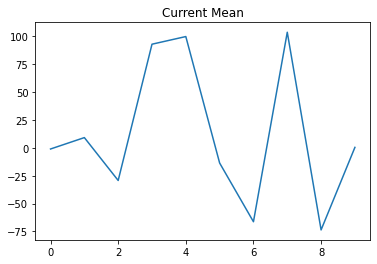

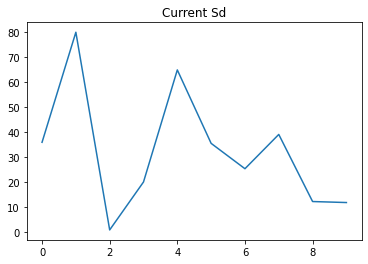

In [0]:
# plot

plt.plot(curr_mean)
plt.title("Current Mean")
plt.show()

plt.plot(curr_sd)
plt.title("Current Sd")
plt.show()

### Try different optimization 
Without optimization, it seems too aggressive. So I tried the following optimization. 


#### Epsilon-Greedy strategy with optimistic initialization
1. It will randomly pick one to explore -> keep a constant drive of exploration  
2. Initialize the counter as 10 for each treatment -> try every option at least 10 times  

Also I adjust the values for `eps` and `alpha`

In [0]:
# define some variables and inititialization lists 

eps = 0.5  # force to explore 50% of the time 
alpha = 0.01 # predefined significance level for T-test
M = 10000000000 # some very large number 
neg_M = -10000000000 # some very small number 
required_info = 300 # how many rounds I require before the first T-test is conducted

curr_mean_opt = [[] for _ in range(k)]
curr_sd_opt = [[] for _ in range(k)]
aban_opt = [] # record abandoned treatment
reward_record_opt = [[] for _ in range(k)] # initialize an empty list to store the reward for each treatment 
curr_values_opt = [10]*k  # initial values for each treatment 
counter_opt = [0]*k # initialize current sd for each treatment, will be updated or appended 

In [0]:
for n in range(N): # N = 1000 = subject number
    # print('subject: ', n) #subject

    # ========================================================================================================
    # ========================================================================================================
    # for each subject i.e. each round, before assigning a treatment, 
    # use T-test to decide whether the current worst is significantly inferior to the current best condition 

    # best condition 
    best_idx = np.argmax(curr_values_opt)
    a = 0
    while(a < len(aban_opt)): 
        if best_idx in aban_opt: # that is, we select the Inf set in the last round 
            curr_values_opt[best_idx] = neg_M # set -Inf to avoid picking the abandoned one from the last round
            best_idx = np.argmax(curr_values_opt) # select again 
        a += 1
    # print('best_idx: ', best_idx) 
    best_TEs = reward_record_opt[best_idx]
    
    # worst condition 
    worst_idx = np.argmin(curr_values_opt) 
    a = 0
    while(a < len(aban_opt)): 
        if worst_idx in aban_opt: 
            curr_values_opt[worst_idx] = M # set Inf to avoid picking it 
            worst_idx = np.argmin(curr_values_opt) # select again 
        a += 1 
    # print('worst_idx: ', worst_idx) 
    worst_TEs = reward_record_opt[worst_idx]

    # T-test, and we only do T-test after some rounds to make sure enough samples 
    if n > required_info: 
        p_value = stats.ttest_ind(best_TEs, worst_TEs, equal_var=False).pvalue
        # print('p value: ', p_value)

        # decide whether abandon a treatment or not
        if p_value < alpha: 
            aban_opt.append(worst_idx) # record the abandoned worst_idx in aban_opt[]
            # print('abandoned: ', aban_opt) 
    
    # ========================================================================================================
    # ========================================================================================================
    # after deciding whether to abandon some treatment, we then assign treatment from the remained

    # every time, pick a treatment to assign to current subject 
    treatment_idx = best_idx # treatment_idx = np.argmax(curr_values_opt) 
    explore = np.random.binomial(1, eps) # throw a coin to decide whether to explore (eps=0.2) or exploit (1-eps=0.8)
    if explore: 
        # randomly try another treatment 
        treatment_idx = np.random.choice(np.setdiff1d(range(k), treatment_idx))
    # print('treatment index: ', treatment_idx) # treatment_idx is the real index that we draw as treatment for this round 
    
    # assign and get the reward
    reward = assign(treatment_idx)
    # print('TE: ', reward) 
    
    # append reward to its action position 
    reward_record_opt[treatment_idx].append(reward) 

    for i in range(k): # within each treatment, loop through k times 
        TE_avg = np.mean(reward_record_opt[i])
        # print('avg: ', TE_avg)
        curr_mean_opt[i] = TE_avg # upeate current mean for each treatment 
        
        TE_sd = np.std(reward_record_opt[i])
        # print('sd: ', TE_sd)
        curr_sd_opt[i] = TE_sd # upeate current sd for each treatment 
    # print('===================')
    
    # update curr_values_opt, counter_opt for each treatment 
    curr_values_opt, counter_opt = value_est(curr_values_opt, counter_opt, treatment_idx, reward)

In [0]:
# aban can show the order of abandoned treatment 
aban_opt

# this time treatment indexed 3, 4, 7 are not abandoned, not that aggressive as last time  

Out[184]: [8, 6, 2, 9, 5, 0, 1]

In [0]:
# current sd for each treatment 
curr_sd_opt

Out[186]: [32.044556874837696,
 57.14082485460491,
 0.9245450130348438,
 21.041176770969944,
 63.5961985774822,
 32.60259446446958,
 30.390544410056144,
 36.897098383127776,
 10.808377162384836,
 12.604268864514381]

In [0]:
# how many times each treatment has been assigned 
counter_opt

# this time it's obvious that each treatments has been tried more fairly   

Out[187]: [60, 52, 57, 460, 64, 57, 64, 56, 67, 63]

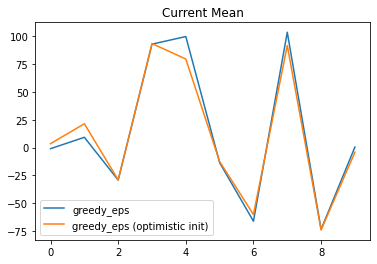

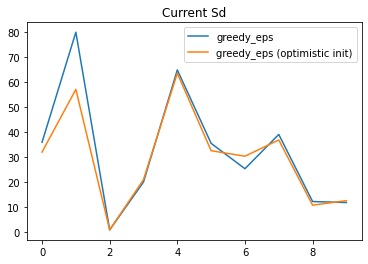

In [0]:
# plot

plt.plot(curr_mean)
plt.plot(curr_mean_opt)
plt.title("Current Mean")
plt.legend(["greedy_eps", "greedy_eps (optimistic init)"])
plt.show()

plt.plot(curr_sd)
plt.plot(curr_sd_opt)
plt.title("Current Sd")
plt.legend(["greedy_eps", "greedy_eps (optimistic init)"])
plt.show()

#### Upper-Confidence-Bound (UCB) Strategy
Strategically explore the actions that are under-explored.

In [0]:
# let's define a function to calculate the adjusted values under UCB
def ucb_calc(curr_values, t, counter, c):
    ucb_values = [0]*len(curr_values)
    for i in range(k):
        if counter[i] == 0:
            ucb_values[i] = curr_values[i] + 9999.99   # some very large number to represent "infinity"
        else:
            ucb_values[i] = curr_values[i] + c * np.sqrt(np.log(t) / counter[i])
    return ucb_values

In [0]:
# define some variables and inititialization lists 
# c = 0.1  # mildly exploration
c = 5  # very aggressive exploration
eps = 0.5  # force to explore 50% of the time 
alpha = 0.01 # predefined significance level for T-test
M = 10000000000 # some very large number 
neg_M = -10000000000 # some very small number 
required_info = 300 # how many rounds I require before the first T-test is conducted

curr_mean_ucb = [[] for _ in range(k)]
curr_sd_ucb = [[] for _ in range(k)]
aban_ucb = [] # record abandoned treatment
reward_record_ucb = [[] for _ in range(k)] # initialize an empty list to store the reward for each treatment 
curr_values_ucb = [10]*k  # initial values for each treatment 
counter_ucb = [0]*k # initialize current sd for each treatment, will be updated or appended 

In [0]:
for n in range(N): # N = 1000 = subject number
    # print('subject: ', n) #subject

    # ========================================================================================================
    # ========================================================================================================
    # for each subject i.e. each round, before assigning a treatment, 
    # use T-test to decide whether the current worst is significantly inferior to the current best condition 

    # do the UCB value adjustments
    ucb_values = ucb_calc(curr_values_ucb, n+1, counter_ucb, c)

    # best condition 
    best_idx = np.argmax(ucb_values)
    a = 0
    while(a < len(aban_ucb)): 
        if best_idx in aban_ucb: # that is, we select the Inf set in the last round 
            ucb_values[best_idx] = neg_M # set -Inf to avoid picking the abandoned one from the last round
            best_idx = np.argmax(ucb_values) # select again 
        a += 1
    # print('best_idx: ', best_idx) 
    best_TEs = reward_record_ucb[best_idx]
    
    # worst condition 
    worst_idx = np.argmin(ucb_values) 
    a = 0
    while(a < len(aban_ucb)): 
        if worst_idx in aban_ucb: 
            ucb_values[worst_idx] = M # set Inf to avoid picking it 
            worst_idx = np.argmin(ucb_values) # select again 
        a += 1 
    # print('worst_idx: ', worst_idx) 
    worst_TEs = reward_record_ucb[worst_idx]

    # T-test, and we only do T-test after some rounds to make sure enough samples 
    if n > required_info: 
        p_value = stats.ttest_ind(best_TEs, worst_TEs, equal_var=False).pvalue
        # print('p value: ', p_value)

        # decide whether abandon a treatment or not
        if p_value < alpha: 
            aban_ucb.append(worst_idx) # record the abandoned worst_idx in aban_ucb[]
            # print('abandoned: ', aban_ucb) 
    
    # ========================================================================================================
    # ========================================================================================================
    # after deciding whether to abandon some treatment, we then assign treatment from the remained

    # every time, pick a treatment to assign to current subject 
    treatment_idx = best_idx
    explore = np.random.binomial(1, eps) # throw a coin to decide whether to explore (eps=0.2) or exploit (1-eps=0.8)
    if explore: 
        # randomly try another treatment 
        treatment_idx = np.random.choice(np.setdiff1d(range(k), treatment_idx))
    # print('treatment index: ', treatment_idx) # treatment_idx is the real index that we draw as treatment for this round 
    
    # assign and get the reward
    reward = assign(treatment_idx)
    # print('TE: ', reward) 
    
    # append reward to its action position 
    reward_record_ucb[treatment_idx].append(reward) 

    for i in range(k): # within each treatment, loop through k times 
        TE_avg = np.mean(reward_record_ucb[i])
        # print('avg: ', TE_avg)
        curr_mean_ucb[i] = TE_avg # upeate current mean for each treatment 
        
        TE_sd = np.std(reward_record_ucb[i])
        # print('sd: ', TE_sd)
        curr_sd_ucb[i] = TE_sd # upeate current sd for each treatment 
    # print('===================')

    # update curr_values_ucb, counter_ucb for each treatment 
    curr_values_ucb, counter_ucb = value_est(curr_values_ucb, counter_ucb, treatment_idx, reward)

In [0]:
# aban can show the order of abandoned treatment 
aban_ucb 

# treatment indexed 3, 4, 7 are still not abandoned

Out[248]: [8, 6, 2, 9, 5, 0, 1]

In [0]:
# current mean for each treatment 
curr_mean_ucb

Out[249]: [3.851325277162132,
 6.120380431734214,
 -28.95349330726779,
 89.22366750302619,
 80.49826824706449,
 -8.324317646085236,
 -57.820672982011146,
 95.08749087020306,
 -78.35326956308073,
 -4.596156460026269]

In [0]:
# current sd for each treatment 
curr_sd_ucb

Out[250]: [25.200847757702608,
 72.0827676613757,
 0.8571158911588708,
 20.962953223394948,
 54.58296330920332,
 30.008134253636758,
 27.350840234223785,
 45.18529963169172,
 10.668597455382463,
 14.9388691314024]

In [0]:
# how many times each treatment has been assigned 
counter_ucb

Out[251]: [52, 56, 55, 50, 66, 50, 67, 489, 52, 63]

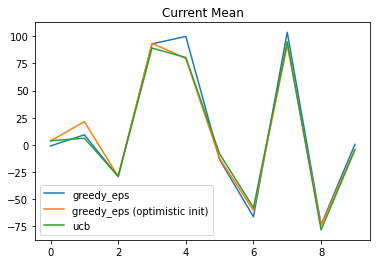

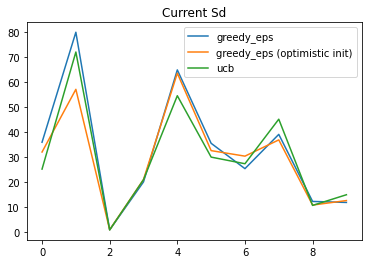

In [0]:
# plot

plt.plot(curr_mean)
plt.plot(curr_mean_opt)
plt.plot(sumreward_ucb)
plt.title("Current Mean")
plt.legend(["greedy_eps", "greedy_eps (optimistic init)", "ucb"])
plt.show()

plt.plot(curr_sd)
plt.plot(curr_sd_opt)
plt.plot(sumreward_ucb)
plt.title("Current Sd")
plt.legend(["greedy_eps", "greedy_eps (optimistic init)", "ucb"])
plt.show()

### Conclusion

From the last comparison plot we can see that, in terms of abandoning treatments with lower average current reward (current mean), greedy + eps is a more agressive strategy in abandoning ineffective treatments since it only retains treatment 7, while other two strategies retain treatments 3, 4, 7. In terms of sd, greedy + eps has the least tolerance to treatments with high sd, while ucb and greedy + eps + opt_initial are more tolerant to larger sd since they still retains treatments with higher sd (4, 7), considering their high means.  

And whether the mentioned above could be good properties should depends on more concrete information about the treatment effects (e.g., how food/bad an effect is compared to others), which will vary with the situations, but in the end, this is the demonstration for the cost-aware A/B testing where by incorporating T-test, we are able to see treatments with low effect to be abandoned to achieve lower cost while find the best treatment.  